# Training WearMaskNet

## Imports

In [1]:
import os, shutil
import zipfile
import numpy as np
import pandas as pd
import glob
from bs4 import BeautifulSoup as bs
import os
import xml.etree.ElementTree as et
import re
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pandas as pd
import glob
import os
import random as rand

from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

import os

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 747753871174241385
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10768782464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11062674758841585529
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:3d:00.0, compute capability: 6.1"
]


## Dataset

In [2]:
def get_dir(classification, split, base_dir='../data/'):
    directory = os.path.join(base_dir, split)
    return os.path.join(directory, classification)

Below, you can see the number of Training, Test and Validation images for each class.

In [3]:
split = 'Train'
temp = get_dir('WithMask', split)
print(f'Total {split} WithMask images:', len(os.listdir(temp)))
temp = get_dir('WithoutMask', split)
print(f'Total {split} WithoutMask images:', len(os.listdir(temp)))
temp = get_dir('Incorrect', split)
print(f'Total {split} Incorrect images:', len(os.listdir(temp)))

split = 'Test'
temp = get_dir('WithMask', split)
print(f'Total {split} WithMask images:', len(os.listdir(temp)))
temp = get_dir('WithoutMask', split)
print(f'Total {split} WithoutMask images:', len(os.listdir(temp)))
temp = get_dir('Incorrect', split)
print(f'Total {split} Incorrect images:', len(os.listdir(temp)))

split = 'Validation'
temp = get_dir('WithMask', split)
print(f'Total {split} WithMask images:', len(os.listdir(temp)))
temp = get_dir('WithoutMask', split)
print(f'Total {split} WithoutMask images:', len(os.listdir(temp)))
temp = get_dir('Incorrect', split)
print(f'Total {split} Incorrect images:', len(os.listdir(temp)))

Total Train WithMask images: 5000
Total Train WithoutMask images: 5000
Total Train Incorrect images: 4820
Total Test WithMask images: 483
Total Test WithoutMask images: 509
Total Test Incorrect images: 500
Total Validation WithMask images: 400
Total Validation WithoutMask images: 400
Total Validation Incorrect images: 400


## Creating Training and Test Data Generators
We didn't do any more data augmentation because we found that it doesn't help our model that much. 

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen =  ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    get_dir('', 'Train'), 
    target_size=(108, 108), 
    batch_size=64,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    get_dir('', 'Validation'),
    target_size=(108, 108), 
    batch_size=64, 
    class_mode='categorical')

Found 14820 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


In [5]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (64, 108, 108, 3)
labels batch shape: (64, 3)


## Model Architecture
We used a base of MobileNetV2 for our WearMaskNet architecture. We then added a simple convolution later and fully-connected layer on its head.  

In [6]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(108, 108, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (thi|s will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

Here's our architecture. You can see that we have around 2,340,163 parameters but we will only train 82,179 of that. 

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 108, 108, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 54, 54, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 54, 54, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 54, 54, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

## Model Training

In [8]:
INIT_LR = 1e-4
EPOCHS = 20

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [9]:
# H = model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=validation_generator)

## Save Model

In [10]:
# model.save('../models/final_model.h5')

# model_json = model.to_json()
# with open("../models/final_model.json", "w") as json_file:
#     json_file.write(model_json)

## Load Model

In [11]:
from keras.models import model_from_json
# load json and create model
json_file = open("../models/final_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

model.load_weights("../models/final_model.h5")

model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# Test Performance

## Test Generator

In [12]:
test_datagen =  ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    get_dir('', 'Test'),
    target_size=(108, 108), 
    batch_size=1, 
    class_mode='categorical', 
    shuffle=True)

Found 1492 images belonging to 3 classes.


## Generating Test Predictions

In [13]:
from tqdm import tqdm

import time

y_pred = []
y_test = []
i = 0

processing_time_list = []

for data_batch, labels_batch in tqdm(test_generator):
    start = time.time()
    if i == len(test_generator):
        break
    res = np.argmax(model.predict(data_batch), axis=1)
    y_pred += [res]
    y_test += [np.argmax(labels_batch, axis=1)]
    i += 1
    elapsed_secs = time.time() - start
    processing_time_list += [elapsed_secs]

y_pred = np.concatenate(y_pred)
y_test = np.concatenate(y_test)

100%|██████████| 1492/1492 [01:27<00:00, 17.05it/s]


## WearMaskNet Model Test Performance

In [14]:
target_names = ['Mask worn incorrectly', 'With Mask', 'No Mask']
print(classification_report(y_test, y_pred, target_names=target_names, 
                            digits=4))
print(f"Test Accuracy: {np.mean(y_pred==y_test)*100:.2f}%")

                       precision    recall  f1-score   support

Mask worn incorrectly     0.9920    0.9960    0.9940       500
            With Mask     0.9876    0.9917    0.9897       483
              No Mask     0.9980    0.9902    0.9941       509

             accuracy                         0.9926      1492
            macro avg     0.9926    0.9926    0.9926      1492
         weighted avg     0.9926    0.9926    0.9926      1492

Test Accuracy: 99.26%


## WearMaskNet Model Prediction Time

In [15]:
mean = np.mean(processing_time_list)*1000
std = np.std(processing_time_list)*1000

print(f"Average Prediction Time: {mean:.0f}ms")
print(f"Standard Deviation: {std:.0f}ms")

Average Prediction Time: 54ms
Standard Deviation: 70ms


## Sample Prediction for People With Mask

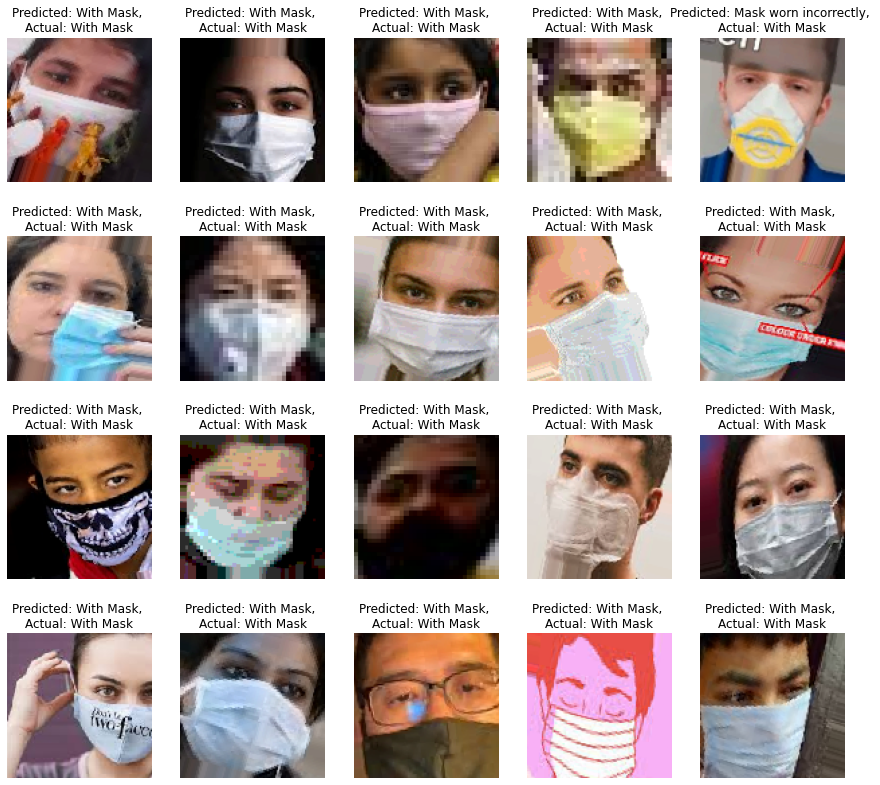

In [16]:
total_count = 20
cols = 5
rows = 4
labels_dict={0:'Mask worn incorrectly',1:'With Mask', 2:'No Mask'}

fig, axes = plt.subplots(rows, cols, figsize=(15, 14))
axes = axes.flatten()
i = 0
for data_batch, labels_batch in test_generator:
    if i == total_count:
        break
        
    res = np.argmax(model.predict(data_batch)[0])
    prediction_idx = np.argmax(labels_batch[0])
    
    if prediction_idx != 1:
        continue
    
    title = (f"Predicted: {labels_dict[res]}, "
             f"\nActual: {labels_dict[prediction_idx]}")
    
    axes[i].set_title(title)
    axes[i].imshow(data_batch[0])
    axes[i].axis('off')
    
    i += 1

## Sample Prediction for People Without Mask

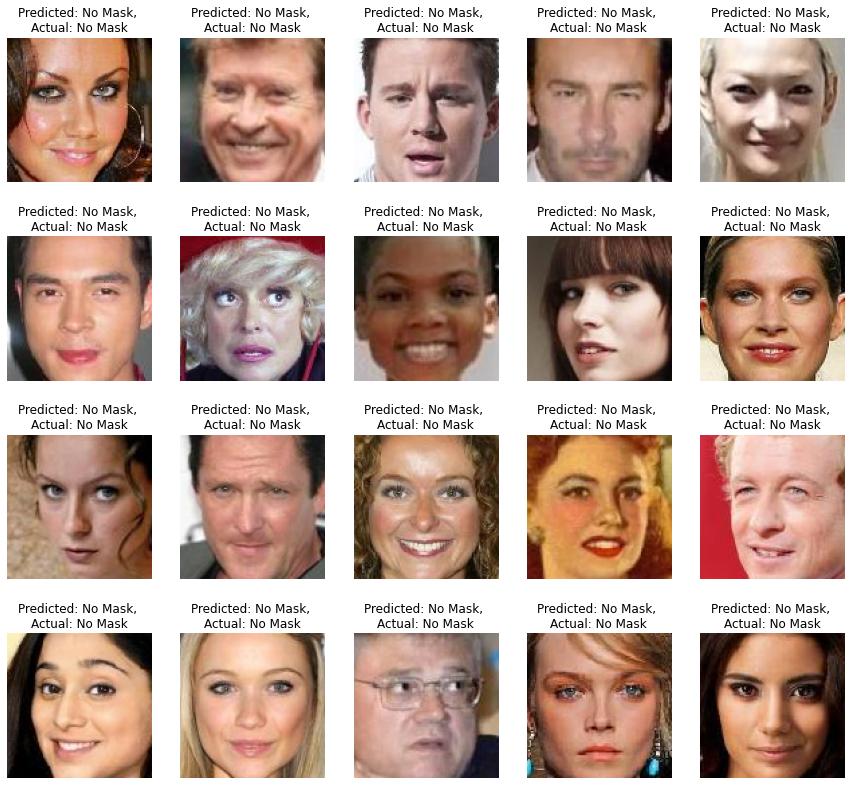

In [17]:
total_count = 20
cols = 5
rows = 4
labels_dict={0:'Mask worn incorrectly',1:'With Mask', 2:'No Mask'}

fig, axes = plt.subplots(rows, cols, figsize=(15, 14))
axes = axes.flatten()
i = 0
for data_batch, labels_batch in test_generator:
    if i == total_count:
        break
        
    res = np.argmax(model.predict(data_batch)[0])
    prediction_idx = np.argmax(labels_batch[0])
    
    if prediction_idx != 2:
        continue
    
    title = (f"Predicted: {labels_dict[res]}, "
             f"\nActual: {labels_dict[prediction_idx]}")
    
    axes[i].set_title(title)
    axes[i].imshow(data_batch[0])
    axes[i].axis('off')
    
    i += 1

## Sample Prediction for People With Incorrectly Worn Mask

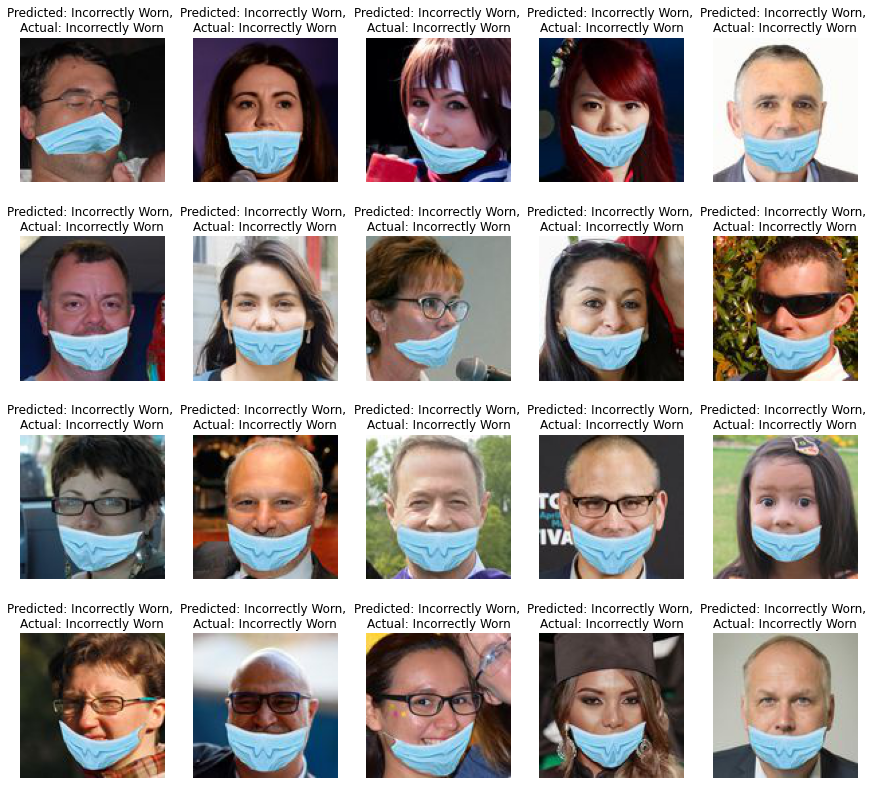

In [18]:
total_count = 20
cols = 5
rows = 4
labels_dict={0:'Incorrectly Worn',1:'With Mask', 2:'No Mask'}

fig, axes = plt.subplots(rows, cols, figsize=(15, 14))
axes = axes.flatten()
i = 0
for data_batch, labels_batch in test_generator:
    if i == total_count:
        break
        
    res = np.argmax(model.predict(data_batch)[0])
    prediction_idx = np.argmax(labels_batch[0])
    
    if prediction_idx != 0:
        continue
    
    title = (f"Predicted: {labels_dict[res]}, "
             f"\nActual: {labels_dict[prediction_idx]}")
    
    axes[i].set_title(title)
    axes[i].imshow(data_batch[0])
    axes[i].axis('off')
    
    i += 1